In [1]:
%load_ext autoreload
%autoreload 2

Test new physics simulation, cell classes, and mothermachine geometry.

In [1]:
from SyMBac.cell_simulation import run_simulation, create_space, trench_creator, step_and_update3
from SyMBac.trench_geometry import trench_creator2
from SyMBac.mothermachine_geometry import Mothermachine, MothermachinePart
from SyMBac.cell import Cell, CellIDFactory, create_width_callable, create_lysis_callable
import numpy as np
from pymunk.pyglet_util import DrawOptions
import pymunk
import pyglet
import time
gravity = 0 
pix_mic_conv = 0.065
trench_length = 12
trench_width = 1.1
cell_max_length = 4
cell_width = 1
max_length_var = 0
width_var = 0
lysis_p = 0.0 # TODO This bugs. Cells are being thrown out of trenches.
show_window = True
phys_iters = 10
sim_length = 100
save_dir = "/tmp/"

space = create_space()
space.gravity = 0, gravity  # arbitrary units, negative is toward trench pole
space.collision_slop = 0.
dt = 1 / 100  # time-step per frame
scale_factor = 1 / pix_mic_conv # resolution scaling factor

trench_length = trench_length * scale_factor
trench_width = trench_width * scale_factor
channel_width = 2 * trench_length
mothermachine = Mothermachine(
    space=space,
    trench_width=trench_width,
    trench_length=trench_length,
    trench_spacing=4*trench_width,
    num_trenches=4,
    channel_width=channel_width,
)


cell_id_factory = CellIDFactory()
cells = []
for i in mothermachine.get_trench_ids():
    cell_length = cell_max_length * 0.9 * scale_factor
    trench_position = mothermachine.get_trench_position(trench_id=i)
    cell_position_x = trench_position[0] + trench_width * 0.5
    if mothermachine.is_top_trench(trench_id=i):
        cell_position_y = trench_position[1] + trench_length - cell_length * 0.5
        mother_above_daughter = True
    else:
        cell_position_y = trench_position[1] + cell_length * 0.5
        mother_above_daughter = False
    cell_pos = (cell_position_x, cell_position_y)
    cell = Cell(
        length=cell_length,
        width=cell_width * scale_factor,
        position=cell_pos,
        id_factory=cell_id_factory,
        self_id = cell_id_factory.get_next_id(),
        angle=np.pi/2,
        max_length=cell_max_length * scale_factor,
        get_width_daughter=create_width_callable(max_width=0.9*trench_width),
        get_lysis_event=create_lysis_callable(lysis_probability=lysis_p),
        mother_above_daughter=mother_above_daughter,
    )
    cells.append(cell)
    cell.shape.color = (255, 0, 0, 255)
    space.add(cell.body, cell.shape)


if show_window:    
    window = pyglet.window.Window(700, 700, "SyMBac", resizable=True)
    options = DrawOptions()
    options.shape_outline_color = (10,20,30,40)
    bb_mothermachine = mothermachine.get_bounding_box(which=MothermachinePart.MOTHERMACHINE)
    scale_x = window.width / (bb_mothermachine.right - bb_mothermachine.left)
    scale_y = window.height / (bb_mothermachine.top - bb_mothermachine.bottom)
    scale_factor = min(scale_x, scale_y)
    window.view = window.view.scale((scale_factor, scale_factor, 1))

    @window.event
    def on_draw():
        window.clear()
        space.debug_draw(options)

    # key press event
    @window.event
    def on_key_press(symbol, modifier):

        # key "E" get press
        if symbol == pyglet.window.key.E:
            # close the window
            window.close()

sim_progress = [0]
cell_timeseries = []
if show_window:
    pyglet.clock.schedule_interval_for_duration(
        step_and_update3, 
        interval=dt, 
        duration=sim_length, 
        cells=cells, 
        space=space, 
        phys_iters=phys_iters,
        cell_timeseries=cell_timeseries, 
        sim_progress=sim_progress, 
        sim_length=sim_length,
        mothermachine=mothermachine
    )
    pyglet.app.run()

_ = input()
pyglet.app.exit()
window.close()


Trench Width: 16.92, Trench Length: 184.62, Trench Spacing: 67.69, Number of Trenches: 4, Channel Width: 369.23, Segment Thickness: 1.00, Left Margin: 67.69, Right Margin: 67.69, Flow Direction: ChannelFlowDirection.RIGHT


Test with configuration objects.

In [1]:
import pyglet

from SyMBac.simulation import Simulation2
from SyMBac.config import TEST_CONFIG_CELL, TEST_CONFIG_MOTHERMACHINE, TEST_CONFIG_SIMULATION

simulation = Simulation2(
    config_simulation=TEST_CONFIG_SIMULATION,
    config_cell=TEST_CONFIG_CELL,
    config_mothermachine=TEST_CONFIG_MOTHERMACHINE,
)

simulation.run_simulation()
# simulation.visualise_in_napari()

/home/lady5906/workspace_python/symbac/SyMBac/simulation.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:

simulation.close_simulation()
simulation.draw_simulation_OPL(do_transformation=True)
# import pickle
# fnametmp = "tmp_simulation.p"
# with open(fnametmp, "wb") as f:
#     simulation.get_lysis_event = None
#     pickle.dump(simulation, f, pickle.HIGHEST_PROTOCOL)

In [3]:
from SyMBac.config import TEST_CONFIG_CAMERA, TEST_CONFIG_PSF, SYMBAC_DIR
from SyMBac.PSF import PSF_generator
from SyMBac.renderer import Renderer
from SyMBac.PSF import Camera

import skimage

real_image = skimage.io.imread(SYMBAC_DIR / "EvomachineData/example_image.tiff")
save_mask = str(SYMBAC_DIR /"EvomachineData/testmask.p")

camera = Camera(
    baseline=TEST_CONFIG_CAMERA.baseline,
    sensitivity=TEST_CONFIG_CAMERA.sensitivity,
    dark_noise=TEST_CONFIG_CAMERA.dark_noise,
)

kernel = PSF_generator(
    mode=TEST_CONFIG_PSF.mode,
    radius=TEST_CONFIG_PSF.radius,
    wavelength=TEST_CONFIG_PSF.wavelength,
    NA=TEST_CONFIG_PSF.num_ap,
    n=TEST_CONFIG_PSF.ref_ind,
    resize_amount=1,
    pix_mic_conv=TEST_CONFIG_SIMULATION.pix_mic_conv,
    apo_sigma=0.,
)

renderer = Renderer(
    simulation=simulation, 
    PSF=kernel, 
    real_image=real_image[145:295,545:585], 
    camera=camera,
)

In [4]:
renderer.select_intensity_napari(fname_param=save_mask, auto=False)

Loading mask from /home/lady5906/workspace_python/symbac/EvomachineData/testmask.p


(886, 355)


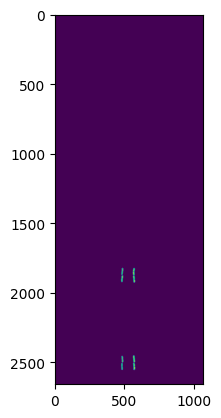

In [6]:
import numpy as np
import matplotlib.pyplot as plt

renderer.real_means = np.array((renderer.real_media_mean, renderer.real_cell_mean, renderer.real_device_mean))
renderer.real_vars = np.array((renderer.real_media_var, renderer.real_cell_var, renderer.real_device_var))
scene_no = -1

expanded_scene, expanded_scene_no_cells, expanded_mask = renderer.generate_PC_OPL(
    scene=renderer.simulation.OPL_scenes[scene_no],
    mask=renderer.simulation.masks[scene_no],
    media_multiplier=75,
    cell_multiplier=1.7,
    device_multiplier=29,
    x_border_expansion_coefficient=renderer.x_border_expansion_coefficient,
    y_border_expansion_coefficient=renderer.y_border_expansion_coefficient,
    defocus=3
)

print(renderer.simulation.OPL_scenes[scene_no].shape)
print(expanded_scene.shape)
plt.imshow(expanded_scene)

In [5]:

renderer.optimise_synth_image(manual_update=True)

interactive(children=(IntSlider(value=75, description='media_multiplier', max=300, min=-300), FloatSlider(valu…